Investigation of Australian Maximum Temperatures
==

Melbourne's maximum temperature on the 6th of January 2018 was 41.7 &deg;C and the forecast maximum for today (7th of January 2018) is 22&deg;C. This got me to wondering how big of drop in maximum daily temperature has occurred between days in the past.

This Jupyter notebook is a summary of what I found.

But first up, some imports:

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point

%matplotlib inline
from matplotlib import pyplot as plt

Accessing a PhilDB database
--
Previously I've downloaded the Bureau of Meteorology ACORN-SAT dataset into a PhilDB instance. An example of PhilDB usage that starts with fetching and storing the data can be found here: https://github.com/amacd31/phildb/blob/master/examples/acorn-sat/ACORN-SAT%20Example.ipynb

Here we access that existing PhilDB instance:

In [2]:
from phildb.database import PhilDB
db = PhilDB('acorn_sat')

Fetch station meta data
--
The PhilDB instance only stores the data stored against each station ID. Therefore to do more detailed analysis (i.e. know more about where a particular time series is from) we need to fetch additional meta data from from the Bureau of Meteorology website.

In [3]:
# Get station list as a Pandas DataFrame
station_list = pd.read_csv('http://www.bom.gov.au/climate/change/acorn-sat/map/stations-acorn-sat.txt')

# Create a station_id column from the stn_num column that has zero left-padded IDs
station_list['station_id'] = station_list['stn_num'].apply(lambda x: '{0:06d}'.format(x))

# Set the zero left-padded IDs as the index
station_list.set_index('station_id', inplace=True)

station_list.head()

,stn_num,stn_name,lat,lon,elevation,start
station_id,,,,,,
001019,1019,Kalumburu,-14.30,126.65,23,1941
002012,2012,Halls Creek,-18.23,127.66,422,1910
003003,3003,Broome Airport,-17.95,122.24,7,1910
004032,4032,Port Hedland,-20.37,118.63,6,1912
004106,4106,Marble Bar,-21.18,119.75,182,1910


Read the data
--

Read the minimum and maximum daily temperature data for all ACORN-SAT stations:

In [4]:
%time daily_max_t = db.read_all('D', measurand = 'maxT', source = 'BOM_ACORN_SAT')
%time daily_min_t = db.read_all('D', measurand = 'minT', source = 'BOM_ACORN_SAT')

CPU times: user 1.99 s, sys: 195 ms, total: 2.18 s
Wall time: 2.36 s
CPU times: user 2.18 s, sys: 219 ms, total: 2.4 s
Wall time: 2.62 s


Amend the data
--
First pass of my investigation found the below massive drop

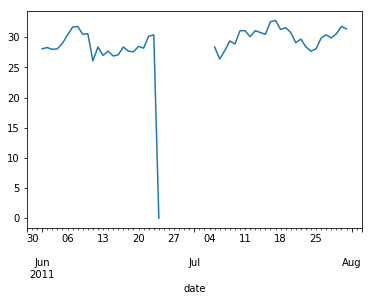

In [5]:
daily_max_t['028004'].loc['2011-06':'2011-07'].plot()

The station in question (see below) is Palmervile which is Northern Queensland, so a maximum temperature of 0 looks spurious.

In [6]:
station_list.loc['028004']

stn_num            28004
stn_name     Palmerville
lat                  -16
lon               144.08
elevation            204
start               1910
Name: 028004, dtype: object

And indeed plotting all the maximum temperatures it appears wildly out of place:

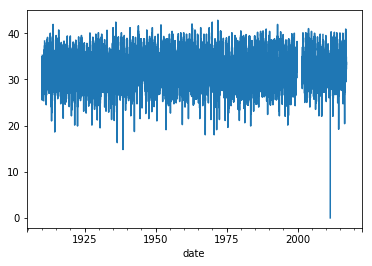

In [7]:
daily_max_t['028004'].plot()

Therefore we remove the zero value and replace it with a missing one before continuing the analysis.

In [8]:
daily_max_t.loc['2011-06-24']['028004'] = np.nan

Prepare mapping elements
--
To produce some maps later we need to set up some mapping components to enable visualisation of the data.

First we need to convert the Lat/Lon fields into Shapely Point objects:

In [9]:
geometry = pd.Series({idx: Point((x,y)) for idx, x, y in zip(station_list.index, station_list.lon, station_list.lat)})

Then we extract Australia from the GeoPandas Natural Earth dataset:

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aus = world[world['name'] == 'Australia']

Now we create the GeoDataFrame from our meta data and the new geometry series we created earlier:

In [11]:
# EPSG 4326 is WGS84, the ACORN-SAT data is possibly GDA94, but for our purposes they are close enough...
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(station_list, geometry=geometry)

Data Analysis
--
The actual work to find the largest increase/decrease between daily temperatures was a simple diff on the series (forwards and reversed), before attaching the maximum change and index of the maximum change to the GeoDataFrame:

In [12]:
gdf['largest_daily_max_increase'] = daily_max_t.diff().max()
gdf['largest_daily_max_increase_date'] = daily_max_t.diff().idxmax()

gdf['largest_daily_max_decrease'] = daily_max_t.iloc[::-1].diff().max()
gdf['largest_daily_max_decrease_date'] = daily_max_t.iloc[::-1].diff().idxmax()

Create the maps
--
Now we can create some maps to visualise the pattern across Australia

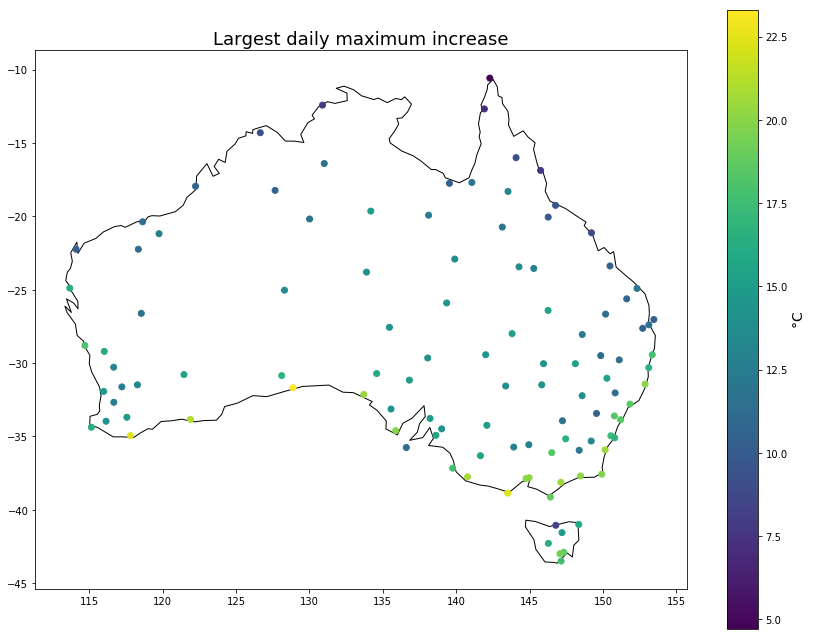

In [13]:
fig, ax = plt.subplots(figsize=(12, 9))

ax.set_aspect('equal')

aus.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, column='largest_daily_max_increase', legend=True)

fig.get_axes()[1].set_ylabel('$\degree$C', fontdict={'fontsize':14})
title = ax.set_title('Largest daily maximum increase', fontdict={'fontsize':18})
plt.tight_layout()
plt.savefig('largest_daily_max_increase.png', facecolor='white')

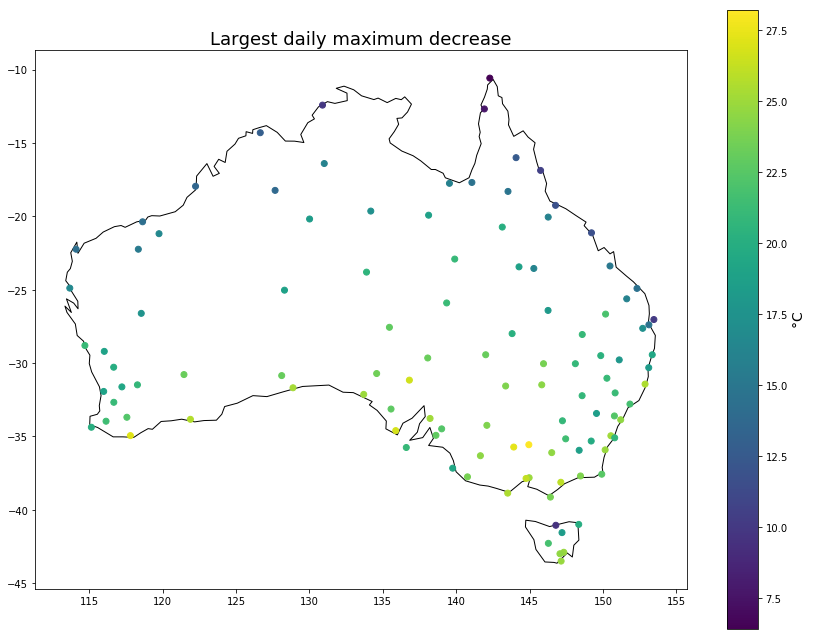

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))

ax.set_aspect('equal')

aus.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, column='largest_daily_max_decrease', legend=True)

fig.get_axes()[1].set_ylabel('$\degree$C', fontdict={'fontsize':14})
title = ax.set_title('Largest daily maximum decrease', fontdict={'fontsize':18})
plt.tight_layout()
plt.savefig('largest_daily_max_decrease.png', facecolor='white')

Largest decrease
--
First a look at the largest daily maximum decrease that has occurred anywhere in the record.

In [15]:
gdf.loc[gdf['largest_daily_max_decrease'].idxmax()]

stn_num                                            74258
stn_name                                      Deniliquin
lat                                               -35.56
lon                                               144.95
elevation                                             94
start                                               1910
geometry                           POINT (144.95 -35.56)
largest_daily_max_increase                          12.8
largest_daily_max_increase_date      1936-11-28 00:00:00
largest_daily_max_decrease                          28.2
largest_daily_max_decrease_date      2005-02-01 00:00:00
Name: 074258, dtype: object

The largest decrease happened in Deniliquin in 2005 from the 1st to the 2nd of Feburary.

So lets take a closer look at the event:

date
2005-01-31    34.5
2005-02-01    39.9
2005-02-02    11.7
2005-02-03    14.0
2005-02-04    19.2
Freq: D, Name: 074258, dtype: float64

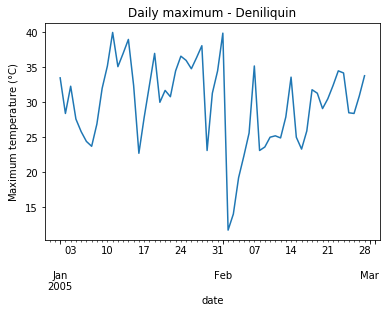

In [16]:
ax = daily_max_t['074258'].loc['2005-01':'2005-02'].plot()
ax.set_title('Daily maximum - Deniliquin')
ax.set_ylabel('Maximum temperature ($\degree$C)')

daily_max_t['074258'].loc['2005-01-31':'2005-02-04']

Largest increase
--
I originally set out to find the largest decrease, but since we're here what about the largest increase?

In [17]:
gdf.loc[gdf['largest_daily_max_increase'].idxmax()]

stn_num                                            11003
stn_name                                           Eucla
lat                                               -31.68
lon                                               128.88
elevation                                             93
start                                               1913
geometry                           POINT (128.88 -31.68)
largest_daily_max_increase                          23.3
largest_daily_max_increase_date      1951-11-18 00:00:00
largest_daily_max_decrease                          25.3
largest_daily_max_decrease_date      1979-11-03 00:00:00
Name: 011003, dtype: object

That goes to Eucla in 1951 from the 18th to the 19th of November.

date
1951-11-16    18.6
1951-11-17    21.1
1951-11-18    44.4
1951-11-19    21.8
1951-11-20    21.1
Freq: D, Name: 011003, dtype: float64

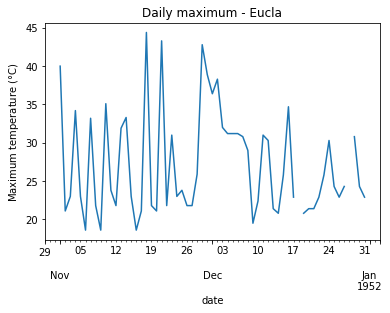

In [18]:
ax = daily_max_t['011003'].loc['1951-11':'1951-12'].plot()
ax.set_title('Daily maximum - Eucla')
ax.set_ylabel('Maximum temperature ($\degree$C)')

daily_max_t['011003'].loc['1951-11-16':'1951-11-20']